In [1]:
import os
import tensorflow.keras as keras
from tensorflow.keras.applications import inception_v3 as inc_net
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tensorflow.keras import backend as K
from sklearn import metrics
import itertools
print('Notebook run using keras:', keras.__version__)
import random
import utils
import pandas as pd
from skimage.transform import resize

nclasses = 6

2022-10-11 10:20:35.895489: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-11 10:20:35.895519: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Notebook run using keras: 2.9.0


In [2]:
#dataset path
path = r'/home/gabriel/Downloads/data_5_v5_Lines_aug/'
dim = (5, 5, 13, 1)

_rows = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(".txt"):
             dic = {}
             dic['path'] = os.path.join(root, file)
             dic['name'] = dic['path'].split(os.path.sep)[-1]
             dic['class'] = dic['path'].split(os.path.sep)[-2]
             dic['set'] = dic['path'].split(os.path.sep)[-3]
             _rows.append(dic)

df = pd.DataFrame.from_records(_rows)
print(df.head())

df['class'] = df['class'].astype(int)
df['class'] = df['class'].values - 1

df_train = df[df['set'] == 'train']
df_val = df[df['set'] == 'validation']
df_test = df[df['set'] == 'test']

train_ids = df_train.path.values
train_classes = {}

for i, row in df_train.iterrows():
    train_classes[row['path']] = int(row['class'])
    
test_ids = df_test.path.values
test_classes = {}

for i, row in df_test.iterrows():
    test_classes[row['path']] = int(row['class'])

val_ids = df_val.path.values
val_classes = {}

for i, row in df_val.iterrows():
    val_classes[row['path']] = int(row['class'])

#PRE-PROCESSING
#max value of uint16
max = 65535

def pre_process(X):
    return np.expand_dims(X, axis=-1)/(max+0.0)


#TRAINING
#train_params = {'ids':train_ids, 'labels':train_classes, 'dim':dim, 'n_classes':nclasses, 'batch_size':batch_size, 'preprocessing':pre_process}
#train_gen = utils.TxtDataGenerator(**train_params)

test_params = {'ids':test_ids, 'labels':test_classes,
               'dim':dim, 'n_classes':nclasses, 'shuffle':False, 'batch_size':1, 'preprocessing':pre_process}
test_gen = utils.TxtDataGenerator(**test_params)

val_params = {'ids':val_ids, 'labels':val_classes, 'dim':dim, 'n_classes':nclasses, 'batch_size':1, 'preprocessing':pre_process}
val_gen = utils.TxtDataGenerator(**val_params)

                                                path                    name  \
0  /home/gabriel/Downloads/data_5_v5_Lines_aug/va...  1057_3044372_(0,0).txt   
1  /home/gabriel/Downloads/data_5_v5_Lines_aug/va...   522_7016187_(0,0).txt   
2  /home/gabriel/Downloads/data_5_v5_Lines_aug/va...  1522_4667812_(0,0).txt   
3  /home/gabriel/Downloads/data_5_v5_Lines_aug/va...   314_7444417_(0,0).txt   
4  /home/gabriel/Downloads/data_5_v5_Lines_aug/va...  1939_3858497_(0,0).txt   

  class         set  
0     1  validation  
1     1  validation  
2     1  validation  
3     1  validation  
4     1  validation  


In [3]:
#definicao do modelo
import tensorflow as tf 
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam,RMSprop, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.applications.xception import preprocess_input
target_size_dimension = 300


img_size = (target_size_dimension, target_size_dimension)
#model path
diretorio_modelo = r'/home/gabriel/Downloads/Baseline3DExtendedExperiment_model__20220822-1215/'

nmodel = tf.keras.models.load_model(diretorio_modelo, compile=False)

nmodel.summary()

2022-10-11 10:20:40.847007: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-11 10:20:40.847035: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-11 10:20:40.847056: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gabriel-ux303ua): /proc/driver/nvidia/version does not exist
2022-10-11 10:20:40.847418: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 5, 13, 1)]     0         
                                                                 
 conv3d (Conv3D)             (None, 5, 5, 13, 32)      896       
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 5, 13, 32)      27680     
                                                                 
 max_pooling3d (MaxPooling3D  (None, 2, 2, 6, 32)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 2, 2, 6, 32)      128       
 ormalization)                                                   
                                                                 
 conv3d_2 (Conv3D)           (None, 2, 2, 6, 32)       27680 

In [4]:
import matplotlib.cm as cm
from IPython.display import Image, display
import tensorflow as tf
from PIL import Image

#define nome dos metodos que o keras usa para criar a visualização
def preprocess_input(X):
    return np.expand_dims(X, axis=-1)/(max+0.0)



def make_gradcam_heatmap(img_array, grad_model, last_conv_layer_name, pred_index=None, tresh=0.1):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    #grad_model = tf.keras.models.Model(
        #[model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    #)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2, 3))
    

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    cam = np.zeros(last_conv_layer_output.shape[0:3], dtype=np.float32)
    
    for index, w in enumerate(pooled_grads):
        cam += w * last_conv_layer_output[:,:,:,index]
    #heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis, tf.newaxis]
    #heatmap = tf.squeeze(heatmap)
    
    

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(cam, 0) / tf.math.reduce_max(cam)
    heatmap = heatmap.numpy()
    return heatmap

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    im = Image.fromarray(heatmap)
    im = im.resize((img.shape[1], img.shape[0]))
    
    im = np.asarray(im)
    im = np.where(im > 0, 1, im)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

 

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    #superimposed_img.save(cam_path)

    # Display Grad CAM
    #display(Image(cam_path))
    return superimposed_img, im


In [5]:
predictions = nmodel.predict(test_gen, steps=len(test_gen))
predicted_classes = np.argmax(predictions, axis=1)
correct_classified = np.where(predicted_classes == df_test['class'].values)[0]

paths = []
for p in correct_classified:
    paths.append(test_ids[p])

model = tf.keras.models.load_model(diretorio_modelo, compile=False)
model.layers[-1].activation = None

last_conv_layer_name = 'conv3d_3'
grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
np.random.seed(16)

individual_results = {}

for img_path in paths:
    class_image = img_path.split(os.path.sep)[-2]
    if not class_image in individual_results:
        individual_results[class_image] = []
    
    img = pre_process(np.load(img_path))
    heatmap = make_gradcam_heatmap(np.expand_dims(img, axis=0), grad_model, last_conv_layer_name)
    heatmap_rs = resize(heatmap, (5,5,13))
    #heatmap_rs = heatmap
    individual_results[class_image].append(heatmap_rs)
    


1118/1118 [==============================] - 4s 3ms/step


Images fot class:  1
[[32 39 25 10 17]
 [41 50 31 12 21]
 [23 28 18  9 13]
 [ 6  6  6  5  6]
 [15 17 12  7 10]]


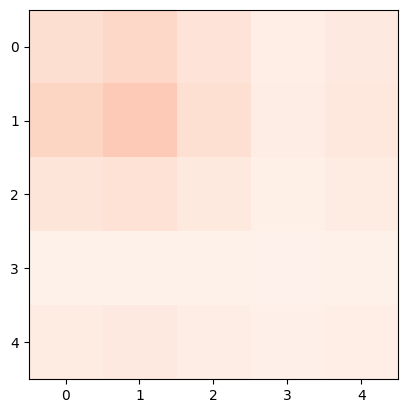

[[11 13  5  0  1  3 20 38 41 42 31 16 19]]


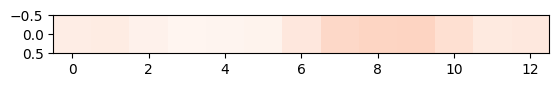

Images fot class:  2
[[64 74 55 37 46]
 [72 82 62 43 53]
 [57 66 48 30 39]
 [41 49 34 18 26]
 [49 57 41 24 32]]


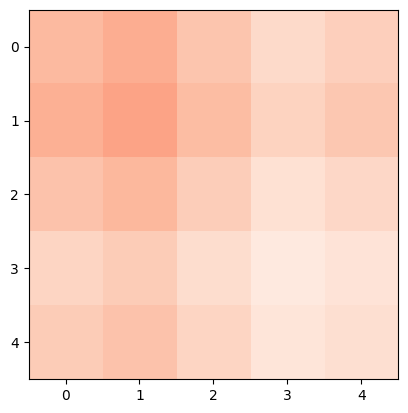

[[55 55 56 57 57 57 63 68 52 34 26 21 22]]


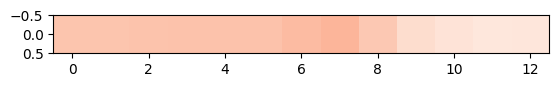

Images fot class:  6
[[36 39 32 26 29]
 [33 38 29 19 24]
 [38 40 36 33 35]
 [43 42 44 47 45]
 [41 41 40 40 40]]


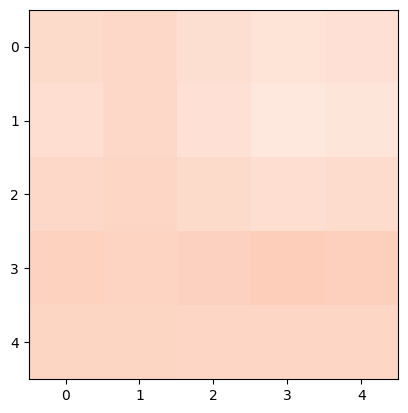

[[49 52 39 31 34 37 36 35 35 36 32 28 29]]


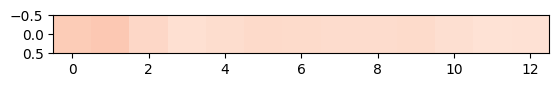

Images fot class:  4
[[57 54 61 67 64]
 [60 56 64 71 67]
 [55 52 58 63 61]
 [50 48 52 56 54]
 [53 50 55 59 57]]


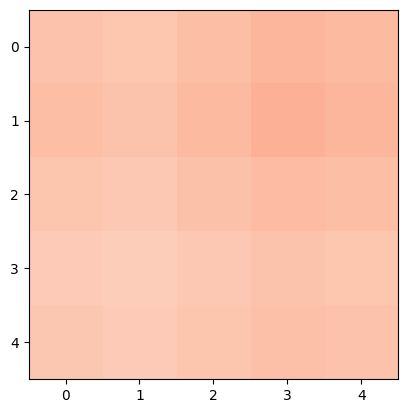

[[ 37  36  44  57  85 107  77  46  55  67  57  40  43]]


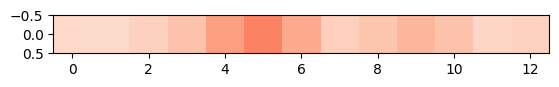

Images fot class:  3
[[ 72  83  60  36  48]
 [ 60  69  50  31  41]
 [ 84  98  70  41  55]
 [108 127  89  51  70]
 [ 96 112  79  46  63]]


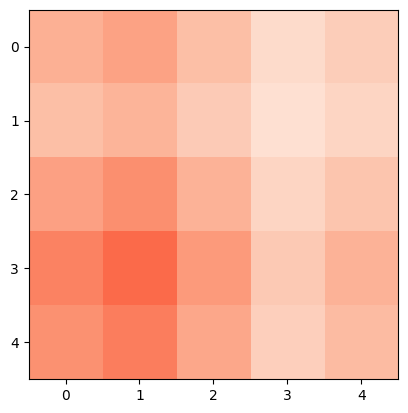

[[67 66 75 78 62 48 59 69 80 91 80 62 65]]


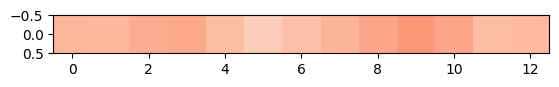

Images fot class:  5
[[100 102  99  95  97]
 [114 122 106  90  98]
 [ 87  82  91 100  96]
 [ 59  42  76 110  93]
 [ 73  62  84 105  94]]


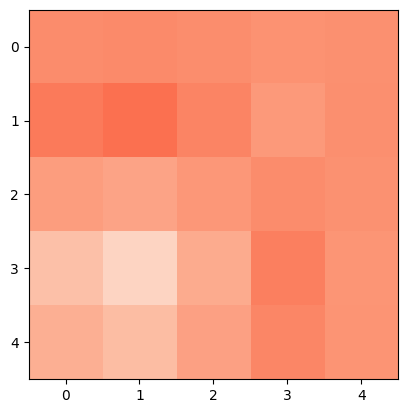

[[ 29  21  70 103  87  75 107 140 143 144 113  73  79]]


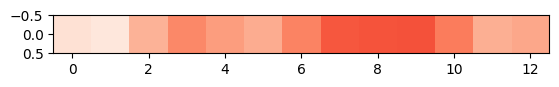

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

for k, v in individual_results.items():
    print('Images fot class: ',k) 
    
    median_cube = np.mean(v, axis=0)
    median_pixel = np.mean(v, axis=(0, -1))
    median_band = np.mean(v, axis=(0, 1, 2))
    heatmap = np.uint8(255 * median_pixel)
    im = Image.fromarray(heatmap)
    
    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("Reds")
    
    print(heatmap)
    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    
    plt.imshow(jet_heatmap)
    plt.show()
    
    heatmap2 = np.expand_dims(np.uint8(255 * median_band), axis=0)
    print(heatmap2)
    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("Reds")
    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap2]
    
    plt.imshow(jet_heatmap)
    plt.show()
    
    
    
    
    
    
    